<a href="https://colab.research.google.com/github/PAVITHRAU/Multimodal-Sentiment-Analysis/blob/main/MVSA_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.1 MB/s eta 0:00:00


In [3]:
import numpy as np
from tqdm.auto import tqdm # this library to create input tensors that the model will use
import tensorflow as tf

In [4]:
import pandas as pd

In [5]:
from transformers import BertTokenizer, AutoTokenizer

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# X_input_ids = np.zeros((len(df), 256))
# X_attn_masks = np.zeros((len(df), 256))

**Preprocessing the sentiment analysis dataset**

In [8]:
import os
import gc
import cv2
import h5py
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from  matplotlib import pyplot as plt

In [9]:

def read_text_file(path, multi_line=False):
#     if multi_line == True:
#         lines = open(path, 'r', encoding='latin-1').readlines()
#         lines = [line.rstrip('\n') for line in lines]
#         return lines
    return open(path, 'r', encoding='latin-1').read()

def read_image_file(path):
    try:
        image = cv2.imread(path)[:, :, ::-1] #, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)

#         image = tf.keras.utils.load_img(path, target_size=IMAGE_SIZE)
#         image = tf.keras.preprocessing.image.img_to_array(image)
        invalid_ID = -1
    except:
        image = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
        invalid_ID = int(os.path.split(path)[1].split('.')[0])
    return image, invalid_ID

def read_labels_file(path):
    dataframe = pd.read_csv(path, sep="\s+|,", engine="python")
    return dataframe

In [10]:
def get_data_paths(path, extension):
    ''' Get list of data paths with input extension and sort by its filename (ID)
    path: Folder path
    extension: File extension wants to get
    '''
    paths = os.listdir(path)
    paths = list(filter(lambda x: x.endswith(extension), paths))
    paths.sort(key = lambda x : int(x.split('.')[0]))
    paths = [os.path.join(path, x) for x in paths]
    return paths

def get_image_with_id(path):
    filename = os.path.split(path)[1]
    ID = int(filename.split('.')[0])
    image = read_image_file(path)
    return (ID, image)

In [11]:
# there are 3 annotators labelling each modality labels in the MVSA-Multiple dataset
# merge those 3 label pairs into 1 pair by taking majority vote on each modality label
# since there are only 3 different labels, if 1 modality receives 3 different labels from 3 annotators
# => the data pair contains it is considered invalid
def merge_multi_label(dataframe):
    anno_1 = list(dataframe.loc[:, ['text', 'image']].itertuples(index=False, name=None))
    anno_2 = list(dataframe.loc[:, ['text.1', 'image.1']].itertuples(index=False, name=None))
    anno_3 = list(dataframe.loc[:, ['text.2', 'image.2']].itertuples(index=False, name=None))
    IDs = list(dataframe.iloc[:, 0])

    valid_pairs = []

    for i in range(len(anno_1)):
        pairs = [anno_1[i], anno_2[i], anno_3[i]]
        ID = IDs[i]

        text_labels = [pair[0] for pair in pairs]
        image_labels = [pair[1] for pair in pairs]

        max_occur_text_label = max(text_labels, key=text_labels.count)
        max_occur_image_label = max(image_labels, key=image_labels.count)

        if text_labels.count(max_occur_text_label) > 1 and image_labels.count(max_occur_image_label) > 1:
            valid_pair = (ID, max_occur_text_label, max_occur_image_label)
        else:
            valid_pair = (ID, 'invalid', 'invalid')
        valid_pairs.append(valid_pair)
    valid_dataframe = pd.DataFrame(valid_pairs, columns=['ID', 'text', 'image'])
    return valid_dataframe

def multimodal_label(text_label, image_label):
    if text_label == image_label:
        label = text_label
    elif (text_label == 'positive' and image_label == 'negative') or (text_label == 'negative' and image_label == 'positive'):
        label = 'invalid'
    elif (text_label == 'neutral' and image_label != 'neutral') or (text_label != 'neutral' or image_label == 'neutral'):
        label = image_label if text_label == 'neutral' else text_label
    return label

In [12]:

def create_multimodal_labels(path, multiple=False, mappings=False):
    dataframe = read_labels_file(path)

    if multiple == True:
        dataframe = merge_multi_label(dataframe)

    labels = []
    for label_pair in dataframe.loc[:, ['text', 'image']].values:
        label = multimodal_label(label_pair[0], label_pair[1])
        labels.append(label)

    if mappings == True:
        label_map = {}
        for i in range(len(labels)):
            ID = dataframe.iloc[i, 0]
            label_map[ID] = labels[i]
        return label_map

    return np.array(labels, dtype='object')

def create_original_labels(path, multiple=False):
    dataframe = read_labels_file(path)

    if multiple == True:
        dataframe = merge_multi_label(dataframe)

    text_labels = dataframe['text'].to_numpy()
    image_labels = dataframe['image'].to_numpy()
    return text_labels, image_labels

def create_text_data(path):
    texts = []
    text_paths = get_data_paths(path, '.txt')

    print('Read text data')
    for text_path in tqdm(text_paths):
        text = read_text_file(text_path).rstrip('\n')
        texts.append(text)

    return texts

def create_image_data(path):
    images = []
    invalid_indices = []
    image_paths = get_data_paths(path, '.jpg')

    print('Read image data')
    for image_path in tqdm(image_paths):
        image, invalid_ID = read_image_file(image_path)
        images.append(image)

        if invalid_ID != -1:
            invalid_indices.append(invalid_ID)

    images = np.array(images, dtype='uint8')
    return images, invalid_indices

In [13]:
def remove_invalid(data, indices):
    valid_data = []
    for i in range(len(data)):
        if i not in indices:
            valid_data.append(data[i])
    return valid_data

In [14]:

def read_hdf5(path):
    read_file = h5py.File(path, 'r')

    feature_names = list(read_file.keys())
    loaded_data = []

    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('utf-8') for x in dataset])
        loaded_data.append((name, dataset))

    return loaded_data

In [15]:
def load_mvsa_data(path):
    data = read_hdf5(path)
    for x in data:
        if x[0] == 'texts':
            texts = x[1]
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]

    images_path = os.path.join(os.path.split(path)[0], os.path.split(path)[1].split('.')[0] + '-images.npz')
    npzfile = np.load(images_path)
    images = npzfile['arr_0']

    return texts, images, labels, text_labels, image_labels

# Read and process raw data

## MVSA-Single

In [16]:
# mvsa_single_texts = create_text_data(mvsa_single_data_path)
# mvsa_single_images, mvsa_single_images_invalid_indices = create_image_data(mvsa_single_data_path)
# mvsa_single_multimodal_labels = create_multimodal_labels(mvsa_single_label_path)
# mvsa_single_text_labels, mvsa_single_image_labels = create_original_labels(mvsa_single_label_path)


In [17]:

mvsa_single_texts_loaded, mvsa_single_images_loaded, \
mvsa_single_multimodal_labels_loaded, mvsa_single_text_labels_loaded, \
mvsa_single_image_labels_loaded = load_mvsa_data('/content/drive/MyDrive/mvsa-data/mvsa-single-4511.hdf5')



In [18]:
# Get duplicated text indices
# mvsa_single_texts_unique_indices = np.unique(mvsa_single_texts, return_index=True)[1]
# mvsa_single_texts_duplicated_indices = [i for i in range(num_mvsa_single) if i not in mvsa_single_texts_unique_indices]

# Get invalid label indices
num_mvsa_single = 4511
mvsa_single_multimodal_labels_invalid_indices = [i for i in range(num_mvsa_single) if mvsa_single_multimodal_labels_loaded[i] == 'invalid']
mvsa_single_multimodal_labels_invalid_indices

[]

In [19]:
print('Number of text-image pair in MVSA-Single:', num_mvsa_single)

# mvsa_single_invalid_indices = []
# # mvsa_single_invalid_indices.extend(mvsa_single_texts_duplicated_indices)
# mvsa_single_invalid_indices.extend(mvsa_single_images_invalid_indices) # corrupted images
# mvsa_single_invalid_indices.extend(mvsa_single_multimodal_labels_invalid_indices)
# mvsa_single_invalid_indices = list(set(mvsa_single_invalid_indices))
# print('Number of invalid data in MVSA-Single:', len(mvsa_single_invalid_indices))

# mvsa_single_texts_valid = remove_invalid(mvsa_single_texts, mvsa_single_invalid_indices)
# mvsa_single_images_valid = remove_invalid(mvsa_single_images, mvsa_single_invalid_indices)
# mvsa_single_multimodal_labels_valid = remove_invalid(mvsa_single_multimodal_labels, mvsa_single_invalid_indices)
# mvsa_single_text_labels_valid = remove_invalid(mvsa_single_text_labels, mvsa_single_invalid_indices)
# mvsa_single_image_labels_valid = remove_invalid(mvsa_single_image_labels, mvsa_single_invalid_indices)

# num_mvsa_single_valid = len(mvsa_single_texts_valid)
# print('Number of text-image pair in MVSA-Single after removing invalid data:', num_mvsa_single_valid)

Number of text-image pair in MVSA-Single: 4511


In [20]:
# save and load check data
# with h5py.File('mvsa-single-{}.hdf5'.format(num_mvsa_single_valid), 'w') as f:
#     f.create_dataset('texts', data = mvsa_single_texts_valid)
# #     f.create_dataset('images', data = mvsa_single_images_valid)
#     f.create_dataset('multimodal-labels', data = mvsa_single_multimodal_labels_valid)
#     f.create_dataset('text-labels', data = mvsa_single_text_labels_valid)
#     f.create_dataset('image-labels', data = mvsa_single_image_labels_valid)

# np.savez('./mvsa-single-{}-images'.format(num_mvsa_single_valid), mvsa_single_images_valid)


## MVSA-Multiple

In [21]:
mvsa_multiple_texts_loaded, mvsa_multiple_images_loaded, \
mvsa_multiple_multimodal_labels_loaded, mvsa_multiple_text_labels_loaded, \
mvsa_multiple_image_labels_loaded = load_mvsa_data('/content/drive/MyDrive//mvsa-data/mvsa-multiple-17024.hdf5')

In [22]:
# mvsa_multiple_texts = create_text_data(mvsa_multiple_data_path)
# mvsa_multiple_images, mvsa_multiple_images_invalid_indices = create_image_data(mvsa_multiple_data_path)
# mvsa_multiple_multimodal_labels = create_multimodal_labels(mvsa_multiple_label_path, multiple=True)
# mvsa_multiple_text_labels, mvsa_multiple_image_labels = create_original_labels(mvsa_multiple_label_path, multiple=True)
# num_mvsa_multiple = len(mvsa_multiple_texts)

In [23]:
# Get duplicated text indices
# mvsa_multiple_texts_unique_indices = np.unique(mvsa_multiple_texts, return_index=True)[1]
# mvsa_multiple_texts_duplicated_indices = [i for i in range(num_mvsa_multiple) if i not in mvsa_multiple_texts_unique_indices]

# Get invalid label indices
mvsa_multiple_multimodal_labels_invalid_indices = [i for i in range(17024) if mvsa_multiple_multimodal_labels_loaded[i] == 'invalid']

In [24]:
# print('Number of text-image pair in MVSA-Multiple:', num_mvsa_multiple)

# mvsa_multiple_invalid_indices = []
# # mvsa_multiple_invalid_indices.extend(mvsa_multiple_texts_duplicated_indices)
# mvsa_multiple_invalid_indices.extend(mvsa_multiple_images_invalid_indices)
# mvsa_multiple_invalid_indices.extend(mvsa_multiple_multimodal_labels_invalid_indices)
# mvsa_multiple_invalid_indices = list(set(mvsa_multiple_invalid_indices))
# print('Number of invalid data in MVSA-Multiple:', len(mvsa_multiple_invalid_indices))

# mvsa_multiple_texts_valid = remove_invalid(mvsa_multiple_texts, mvsa_multiple_invalid_indices)
# mvsa_multiple_images_valid = remove_invalid(mvsa_multiple_images, mvsa_multiple_invalid_indices)
# mvsa_multiple_multimodal_labels_valid = remove_invalid(mvsa_multiple_multimodal_labels, mvsa_multiple_invalid_indices)
# mvsa_multiple_text_labels_valid = remove_invalid(mvsa_multiple_text_labels, mvsa_multiple_invalid_indices)
# mvsa_multiple_image_labels_valid = remove_invalid(mvsa_multiple_image_labels, mvsa_multiple_invalid_indices)

# num_mvsa_multiple_valid = len(mvsa_multiple_texts_valid)
# print('Number of text-image pair in MVSA-Multiple after removing invalid data:', num_mvsa_multiple_valid)

In [25]:
# # save data to file
# with h5py.File('mvsa-multiple-{}.hdf5'.format(num_mvsa_multiple_valid), 'w') as f:
#     f.create_dataset('texts', data = mvsa_multiple_texts_valid)
# #     f.create_dataset('images', data = a, compression="gzip")
#     f.create_dataset('multimodal-labels', data = mvsa_multiple_multimodal_labels_valid)
#     f.create_dataset('text-labels', data = mvsa_multiple_text_labels_valid)
#     f.create_dataset('image-labels', data = mvsa_multiple_image_labels_valid)

# # save as npz since h5py has a memory issues when saving upto 16k data somehow but 13k was fine :)
# np.savez('./mvsa-multiple-{}-images'.format(num_mvsa_multiple_valid), mvsa_multiple_images_valid)

# Visualization

In [26]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
#os.makedirs('./plots')

In [28]:
mvsa_single_multimodal_labels_valid = np.array(mvsa_single_multimodal_labels_loaded)
mvsa_multiple_multimodal_labels_valid = np.array(mvsa_multiple_multimodal_labels_loaded)

In [29]:
mvsa_single_num_pos = (mvsa_single_multimodal_labels_loaded == 'positive').sum()
mvsa_single_num_neg = (mvsa_single_multimodal_labels_loaded == 'negative').sum()
mvsa_single_num_neu = (mvsa_single_multimodal_labels_loaded == 'neutral').sum()

mvsa_multiple_num_pos = (mvsa_multiple_multimodal_labels_loaded == 'positive').sum()
mvsa_multiple_num_neg = (mvsa_multiple_multimodal_labels_loaded == 'negative').sum()
mvsa_multiple_num_neu = (mvsa_multiple_multimodal_labels_loaded == 'neutral').sum()

In [30]:
def get_label_num(data_labels, name=''):
    unique_labels = np.unique(data_labels)
    num_labels = [(data_labels == label).sum() for label in  unique_labels]
    dataframe = pd.DataFrame(np.reshape(num_labels, (1, -1)), columns=unique_labels, index=[name])
    return dataframe

In [31]:
print('MVSA dataset after removing invalid and duplicated data')
mvsa_single_valid_label = get_label_num(mvsa_single_multimodal_labels_loaded, 'MVSA-Single')
mvsa_multiple_valid_label = get_label_num(mvsa_multiple_multimodal_labels_loaded, 'MVSA-Multiple')
mvsa_valid_label = get_label_num(np.append(mvsa_single_multimodal_labels_loaded, mvsa_multiple_multimodal_labels_loaded, axis=0), 'Total MVSA')
mvsa_valid_label = pd.concat([mvsa_single_valid_label, mvsa_multiple_valid_label, mvsa_valid_label])
mvsa_valid_label['total'] = mvsa_valid_label.sum(axis = 1)
mvsa_valid_label
#print(mvsa_single_valid_label, mvsa_single_multimodal_labels_valid)

MVSA dataset after removing invalid and duplicated data


negative  neutral  positive  total
MVSA-Single        1358      470      2683   4511
MVSA-Multiple      1299     4407     11318  17024
Total MVSA         2657     4877     14001  21535

In [32]:
WIDTH = 650
HEIGHT = 400
fig = px.bar(mvsa_valid_label.T.drop('total'), orientation='h')
fig.update_traces(width=0.7)
fig.update_layout(margin_b=25, margin_t=35, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
fig.update_layout(title=' MVSA-Single and MVSA-Multiple',
                  xaxis_title='Number of labels',
                  yaxis_title='Sentiment', legend_title='Legend')
#fig.write_html('./plots/label-statistics.html')
fig.show()

In [33]:
num_mvsa_single_valid=4511
positive_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_loaded[i] == 'positive']
negative_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_loaded[i] == 'negative']
neutral_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_loaded[i] == 'neutral']

Positive images


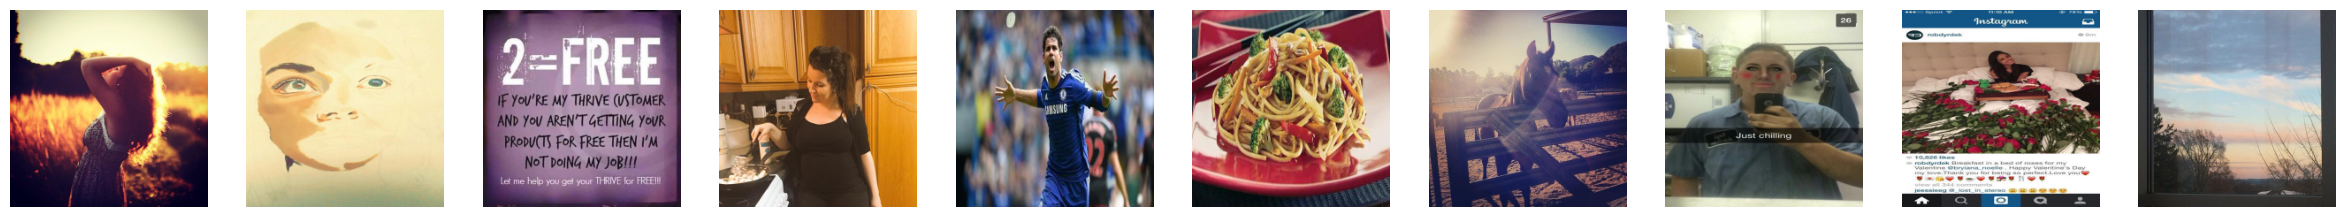

In [34]:
rows = 1
columns = 10

fig = plt.figure(figsize=(30, 5))
print('Positive images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(positive_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
plt.show()

Negative images


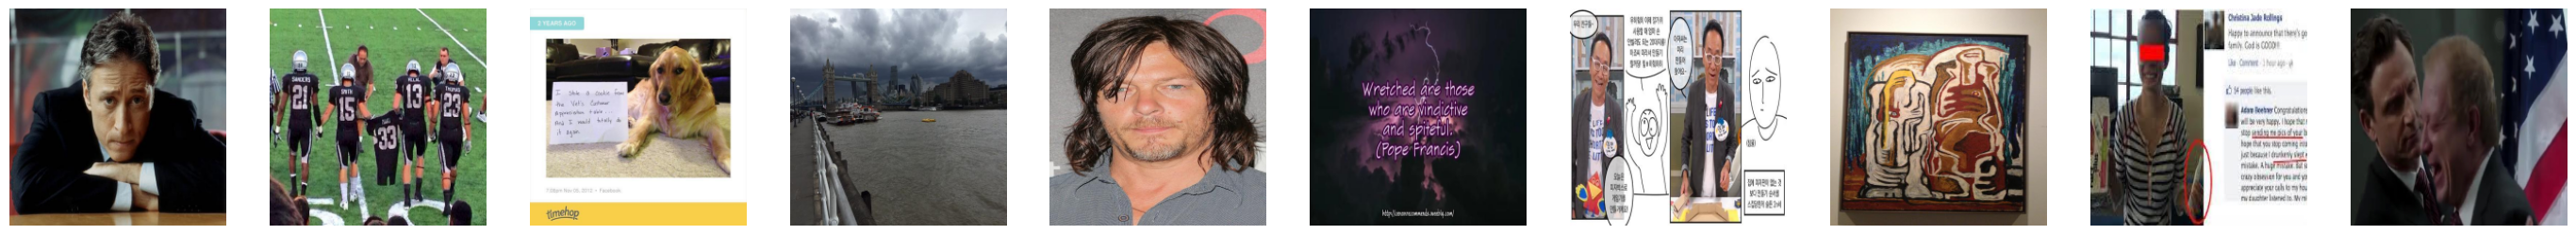

In [35]:
fig = plt.figure(figsize=(35, 10))
print('Negative images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(negative_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
plt.show()

Neutral images


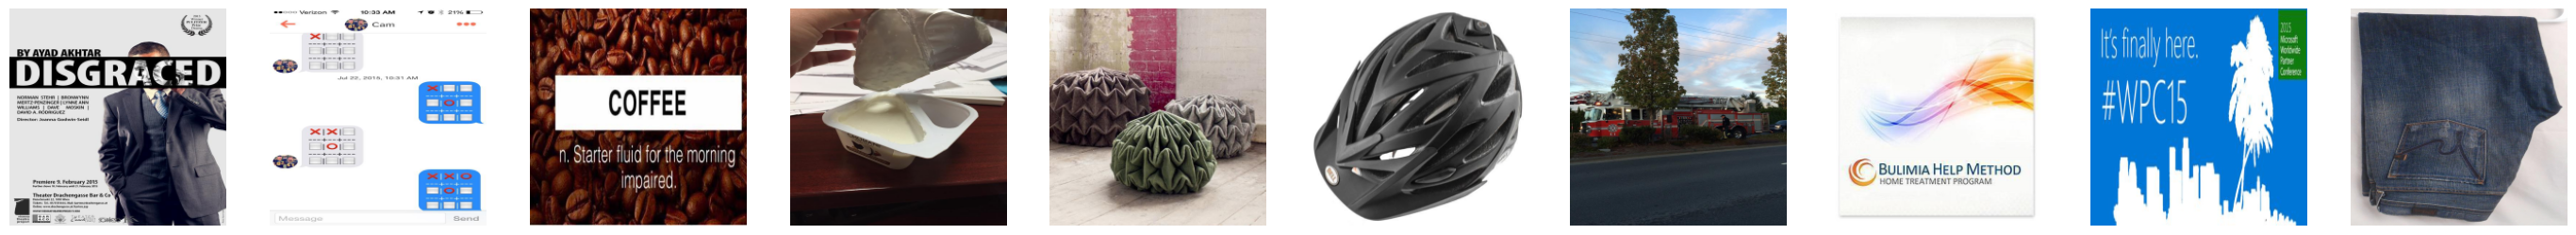

In [36]:
fig = plt.figure(figsize=(35, 10))
print('Neutral images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(neutral_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
plt.show()

Positive images


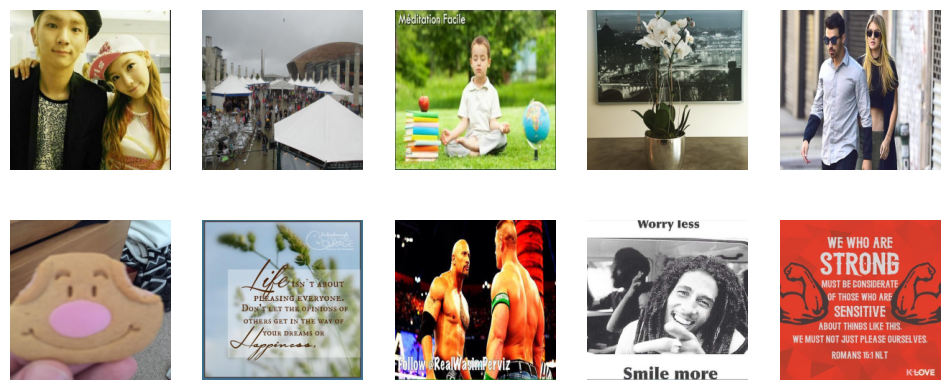

Negative images


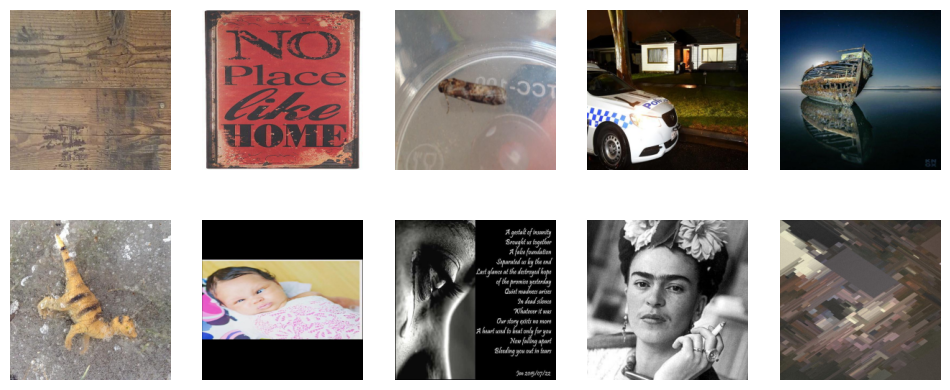

Neutral images


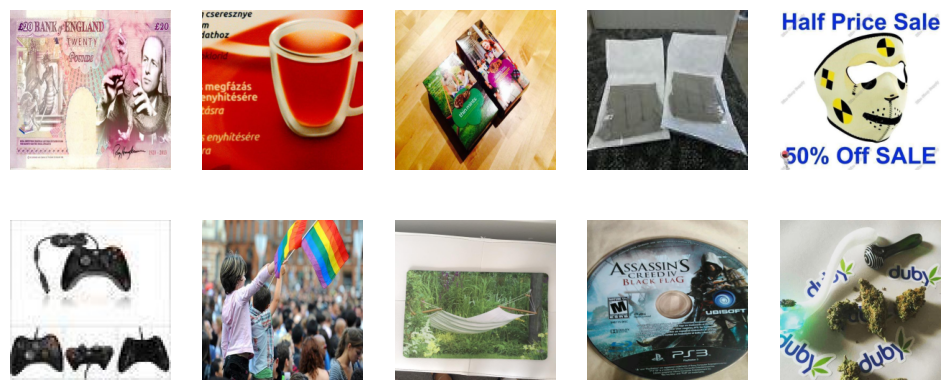

In [37]:
rows = 2
columns = 5

fig = plt.figure(figsize=(12, 5))
print('Positive images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(positive_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
#plt.savefig('./plots/images_positive.png')
plt.show()

fig = plt.figure(figsize=(12, 5))
print('Negative images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(negative_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
#plt.savefig('./plots/images_negative.png')
plt.show()

fig = plt.figure(figsize=(12, 5))
print('Neutral images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(neutral_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
#plt.savefig('./plots/images_neutral.png')
plt.show()

In [38]:
mvsa_single_texts_loaded

array(['How I feel today #legday #jelly #aching #gym ',
       'grattis min griskulting!!!???? va bara tvungen oki s? sch ? @ingenkommeratttrodig #pig #happybday #wow #lovely #cut¡\xad ',
       'RT @polynminion: The moment I found my favourite tV character. #PROFOUNDLOVE ',
       ...,
       'RT @bookmyshow: #Disney\'s lies - "Every day is a good hair day". Yeah, right!!: http://t.co/351AQVV7gA http://t.co/fFH59wGwbs',
       'RT @MUBMI: TWO MORE DAYS to submit your apps #mizzou19 http://t.co/aqhTljfgIG http://t.co/cftTb6ok5b',
       "RT @khununeos: khun was literally me whenever I gotta see junho's sinful butt- lol (crtto) http://t.co/y3IvvUTRYT"],
      dtype='<U257')

In [39]:
# if mvsa_single_texts_loaded[2].startswith('RT'):
#         txt = ''.join(mvsa_single_texts_loaded[2].split(':')[1:])
# txt = mvsa_single_texts_loaded[2].strip().lower()
# txt=clean_text(np.array_str(mvsa_single_texts_loaded[2]))
# print(txt)


import re
import string

at_pattern = re.compile('@[a-zA-Z0-9]+')
http_pattern = re.compile("((http|ftp|https)://)(([a-zA-Z0-9\._-]+\.[a-zA-Z]{2,6})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(:[0-9]{1,4})*(/[a-zA-Z0-9\&%_\./-~-]*)?")
punc_pattern = re.compile('[%s]' % re.escape(string.punctuation))
print(mvsa_single_texts_loaded[2])
txt = re.sub('#', '', mvsa_single_texts_loaded[2])
print(txt)
txt = re.sub(at_pattern, 'user', txt)
print(txt)
txt = re.sub(http_pattern, 'link', txt)
print(txt)
if txt.startswith('RT user'):
  txt = ''.join(txt.split(':')[1:])
print(txt)
txt = re.sub(punc_pattern, '', txt)
print(txt)
#txt.split(':')[1:]
# ONLY REMOVE punc for word2vec not BERT
# as the data was crawled using Twitter API, it marked retweet data with RT <user> tag which has no meaning considering it in training

txt = txt.strip().lower()
print(txt)

RT @polynminion: The moment I found my favourite tV character. #PROFOUNDLOVE 
RT @polynminion: The moment I found my favourite tV character. PROFOUNDLOVE 
RT user: The moment I found my favourite tV character. PROFOUNDLOVE 
RT user: The moment I found my favourite tV character. PROFOUNDLOVE 
 The moment I found my favourite tV character. PROFOUNDLOVE 
 The moment I found my favourite tV character PROFOUNDLOVE 
the moment i found my favourite tv character profoundlove


In [40]:
import re
import string
def clean_text(txt):
  at_pattern = re.compile('@[a-zA-Z0-9]+')
  http_pattern = re.compile("((http|ftp|https)://)(([a-zA-Z0-9\._-]+\.[a-zA-Z]{2,6})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(:[0-9]{1,4})*(/[a-zA-Z0-9\&%_\./-~-]*)?")
  punc_pattern = re.compile('[%s]' % re.escape(string.punctuation))
  txt = re.sub('#', '', txt)
  txt = re.sub(at_pattern, 'user', txt)
  txt = re.sub(http_pattern, 'link', txt)
  # as the data was crawled using Twitter API, it marked retweet data with RT <user> tag which has no meaning considering it in training
  if txt.startswith('RT user'):
    txt = ''.join(txt.split(':')[1:])
    txt = re.sub(punc_pattern, '', txt) # ONLY REMOVE punc for word2vec not BERT
    txt = txt.strip().lower()
  return txt

def get_clean_texts(data):
  cleaned_data = []
  for line in data:
    text = clean_text(line)
    cleaned_data.append(text)
  return cleaned_data

In [41]:
mvsa_texts_valid = get_clean_texts(np.concatenate((mvsa_single_texts_loaded, mvsa_multiple_texts_loaded)))
mvsa_labels_valid = get_clean_texts(np.concatenate((mvsa_single_multimodal_labels_loaded, mvsa_multiple_multimodal_labels_loaded)))

In [42]:
mvsa_texts_valid[:10],

(['How I feel today legday jelly aching gym ',
  'grattis min griskulting!!!???? va bara tvungen oki s? sch ? user pig happybday wow lovely cut¡\xad ',
  'the moment i found my favourite tv character profoundlove',
  'escort We have a young and energetic team and we pride ourselves on offering the highes hoer ',
  'went to ssc today to be a movie star to rep for the deaf and got to meet an energetic great guy mark white',
  'that was really energetic',
  'to my most hard workingfun loving and energetic teamthank you and i love you',
  'Energetic training today with our San Antonio New Dollars/New Partners trainees ',
  'Look at their Photo and feel the Anger. SpeakUp for peace. Speak up for equality. Speak up for Tolerance. ',
  'user absolute disgrace two carriages from Bangor half way there standing room only disgraced '],)

In [43]:
np.concatenate((mvsa_single_texts_loaded, mvsa_multiple_texts_loaded))[:10]

array(['How I feel today #legday #jelly #aching #gym ',
       'grattis min griskulting!!!???? va bara tvungen oki s? sch ? @ingenkommeratttrodig #pig #happybday #wow #lovely #cut¡\xad ',
       'RT @polynminion: The moment I found my favourite tV character. #PROFOUNDLOVE ',
       '#escort We have a young and energetic team and we pride ourselves on offering the highes #hoer ',
       'RT @chrisashaffer: Went to SSC today to be a "movie star" to rep for the Deaf and got to meet an energetic great guy: Mark White! ',
       'RT @babeshawnmendes: "that was really energetic" ',
       'RT @deepikapadukone: To my most hard working,fun loving and energetic team...Thank you and I love you! ',
       'Energetic training today with our San Antonio New Dollars/New Partners trainees ',
       'Look at their Photo and feel the #Anger. #SpeakUp for #peace. Speak up for #equality. Speak up for #Tolerance. ',
       '@ArrivaTW absolute disgrace two carriages from Bangor half way there standing room

In [44]:
len(mvsa_labels_valid), len(mvsa_texts_valid)

(21535, 21535)

In [45]:
mvsa_texts_positive = []
mvsa_texts_negative = []
mvsa_texts_neutral = []
for i in range(len(mvsa_labels_valid)):
    x = mvsa_labels_valid[i]
    y = mvsa_texts_valid[i]
    if x == 'positive':
        mvsa_texts_positive.append(y)
    if x == 'negative':
        mvsa_texts_negative.append(y)
    if x == 'neutral':
        mvsa_texts_neutral.append(y)

In [46]:
# for graphing
len_positive = [len(n) for n in mvsa_texts_positive]
len_negative = [len(n) for n in mvsa_texts_negative]
len_neutral = [len(n) for n in mvsa_texts_neutral]


# Input preprocessing

In [47]:
#pip install transformers

In [48]:
df=pd.DataFrame(data=[mvsa_texts_valid, mvsa_labels_valid]).T
df.columns=['Text','Label']
df

Text     Label
0              How I feel today legday jelly aching gym   positive
1      grattis min griskulting!!!???? va bara tvungen...  positive
2      the moment i found my favourite tv character p...  positive
3      escort We have a young and energetic team and ...  positive
4      went to ssc today to be a movie star to rep fo...  positive
...                                                  ...       ...
21530  user user Mackenzie going to grade 9. Bradley ...  positive
21531  user why no adult MENS version of this user T-...   neutral
21532                           user_ it was this before  positive
21533  user deadline extended for County scholarships...  positive
21534  I usually spend a lot of time at Improv Detroi...  positive

[21535 rows x 2 columns]

In [49]:
df['Label'][df['Label'] == 'neutral'] = 1
df['Label'][df['Label'] == 'negative'] = 0
df['Label'][df['Label'] == 'positive'] = 2

In [50]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [51]:
df

Text Label
0              How I feel today legday jelly aching gym      2
1      grattis min griskulting!!!???? va bara tvungen...     2
2      the moment i found my favourite tv character p...     2
3      escort We have a young and energetic team and ...     2
4      went to ssc today to be a movie star to rep fo...     2
...                                                  ...   ...
21530  user user Mackenzie going to grade 9. Bradley ...     2
21531  user why no adult MENS version of this user T-...     1
21532                           user_ it was this before     2
21533  user deadline extended for County scholarships...     2
21534  I usually spend a lot of time at Improv Detroi...     2

[21535 rows x 2 columns]

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

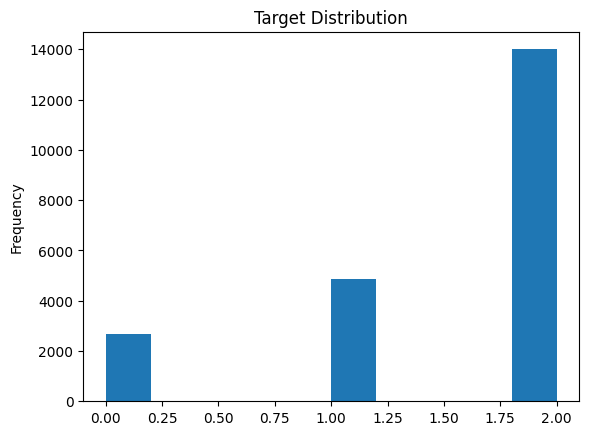

In [52]:
df.Label.plot(kind='hist',title='Target Distribution')

In [53]:
df.shape

(21535, 2)

In [54]:
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [55]:


X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [56]:
X_input_ids, X_attn_masks = preprocessing_dataset(df, X_input_ids, X_attn_masks, tokenizer)


21535it [00:20, 1031.72it/s]


In [57]:
labels = np.zeros((len(df), 3))

In [58]:
labels.shape

(21535, 3)

In [59]:
np.arange(len(df)).shape

(21535,)

In [60]:
labels[np.arange(len(df)), df['Label'].values.astype(int)]=1

In [61]:
#for i in enumerate(labels):
#  print(i)

In [62]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

In [63]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [64]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [65]:
dataset = dataset.map(SentimentDatasetMapFunction)

In [66]:
len(df)

21535

In [67]:
dataset = dataset.shuffle(len(df)).batch(16, drop_remainder=True)

In [68]:
p = 0.8
train_size = int((len(df)//16)*p)
print('train size', train_size)

train size 1076


In [69]:
training_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

In [70]:
from transformers import TFBertModel
from keras.layers import Bidirectional, LSTM, Dropout, Dense

In [71]:
model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [72]:
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')


In [73]:
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1]

In [74]:
reshaped_bert_embds = tf.keras.layers.Reshape((1, -1))(bert_embds)
bi_lstm_layer= Bidirectional(LSTM(25, return_sequences=True))(reshaped_bert_embds)

dropout_layer=Dropout(0.5)(bi_lstm_layer)
flattened_output = tf.keras.layers.Flatten()(dropout_layer)
# Add a Dense layer with ReLU activation and 200 units
dense_layer=Dense(10, activation='relu')(flattened_output)

In [75]:
#intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)

In [76]:
output_layer = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(dense_layer)

In [77]:
sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)

In [78]:
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

In [79]:
optim = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-8)

In [80]:
loss_func = tf.keras.losses.CategoricalCrossentropy()

In [81]:
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [82]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 13.8 MB/s eta 0:00:00


In [83]:
NUM_CLASSES=3
import tensorflow_addons as tfa
f1_macro = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', name='f1_macro')
f1_weighted = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='weighted', name='f1_weighted')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 




In [84]:
sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc, f1_macro, f1_weighted])

In [85]:
model_training = sentiment_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=1
)

1076/1076 [==============================] - 1052s 909ms/step - loss: 0.7768 - accuracy: 0.6722 - f1_macro: 0.4672 - f1_weighted: 0.6079 - val_loss: 0.6600 - val_accuracy: 0.7210 - val_f1_macro: 0.5623 - val_f1_weighted: 0.6648


In [86]:
probs = sentiment_model.predict(validation_dataset)

269/269 [==============================] - 86s 296ms/step


In [87]:
probs

array([[0.04277262, 0.10310146, 0.8541259 ],
       [0.05484245, 0.56705993, 0.37809765],
       [0.03666216, 0.10393606, 0.85940176],
       ...,
       [0.04385177, 0.10246453, 0.85368365],
       [0.6770642 , 0.08102947, 0.24190633],
       [0.04011199, 0.16393028, 0.79595774]], dtype=float32)

In [88]:
pred1 = np.argmax(probs, axis=1)

In [89]:
pred1

array([2, 1, 2, ..., 2, 0, 2])

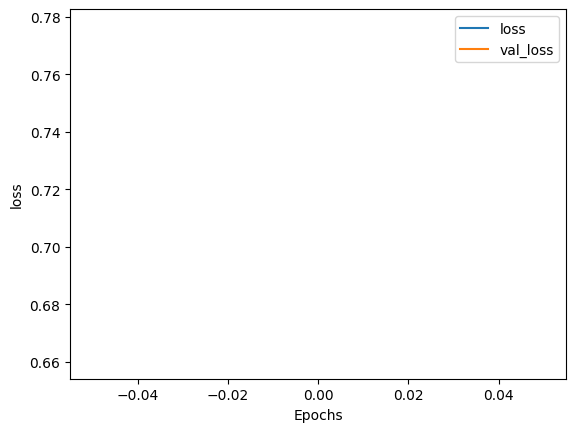

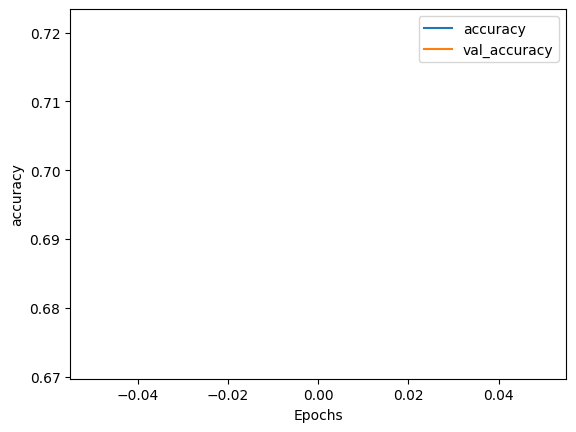

In [90]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()


plot_graphs(model_training,'loss')
plot_graphs(model_training,'accuracy')

In [90]:
sentiment_model.save('/content/drive/MyDrive/my_model1.keras')
#/content/my_model.keras

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-91-9e81b51ee2dc>", line 1, in <cell line: 1>
    sentiment_model.save('/content/drive/MyDrive/my_model1.keras')
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 3079, in save
    saving_api.save_model(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py", line 164, in save_model
    saving_lib.save_model(model, filepath)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py", line 204, in save_model
    weights_store.close()
  File "/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py", line 640, in close
    self.archive.writest

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-91-9e81b51ee2dc>", line 1, in <cell line: 1>
    sentiment_model.save('/content/drive/MyDrive/my_model1.keras')
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 3079, in save
    saving_api.save_model(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py", line 164, in save_model
    saving_lib.save_model(model, filepath)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py", line 204, in save_model
    weights_store.close()
  File "/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py", line 640, in close
    self.archive.writest

TypeError: ignored

In [91]:
y_test=[]
for i in validation_dataset:
  for j in range(16):
    y_test.append(i[1][j].numpy())


In [92]:
y_t=[]
for i in training_dataset:
  for j in range(16):
    y_t.append(i[1][j].numpy())


In [93]:
len(y_test),len(y_t)

(4304, 17216)

In [94]:
y_test1=np.argmax(np.array(y_test),axis=1)

In [95]:
y_test1

array([2, 0, 2, ..., 1, 2, 2])

In [96]:
from sklearn.metrics import classification_report,confusion_matrix
print("Performance Metrics: ")
metrics=classification_report(y_test1,pred1)
print(metrics)

Performance Metrics: 
              precision    recall  f1-score   support

           0       0.11      0.09      0.10       537
           1       0.20      0.05      0.07       945
           2       0.65      0.85      0.74      2822

    accuracy                           0.58      4304
   macro avg       0.32      0.33      0.30      4304
weighted avg       0.49      0.58      0.51      4304



In [97]:
confusion_matrix(y_test1,pred1)

array([[  50,   31,  456],
       [  98,   43,  804],
       [ 296,  140, 2386]])

In [ ]:
from sklearn.model_selection import train_test_split

train_df,remaining = train_test_split(df,random_state=42,train_size=0.8,stratify=df.Label.values)
valid_df,test_df = train_test_split(remaining,random_state=42,train_size=0.5,stratify=remaining.Label.values)
train_df.shape,valid_df.shape, test_df.shape

((17228, 2), (2153, 2), (2154, 2))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.Text.astype('string'), train_df.Label.astype('int64')))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.Text.astype('string'), valid_df.Label.astype('int64')))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'way to go user user user recycle environment kcup timhortons coffee earth', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.14.0


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 29.47 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: switching to '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 35.3 

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 




In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.14.0
Eager mode:  True
Hub version:  0.15.0
GPU is NOT AVAILABLE


In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1, 2] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(),
                                            text_b = None,
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [ ]:
from keras.utils import to_categorical
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  #label_1=to_categorical(label_id, num_classes=3)


  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="softmax", name="output")(drop)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

In [ ]:
import tensorflow_addons as tfa
f1_macro = tfa.metrics.F1Score(num_classes=3, average='macro', name='f1_macro')
f1_weighted = tfa.metrics.F1Score(num_classes=3, average='weighted', name='f1_weighted')

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy', f1_macro, f1_weighted])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

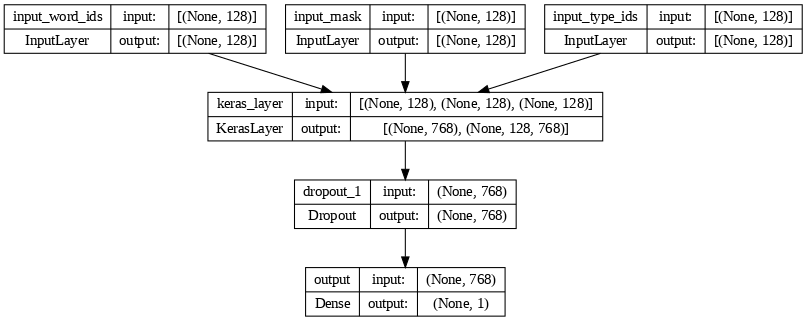

In [ ]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

In [ ]:
epochs=4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    batch_size=128,
                    verbose=1)

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning:

In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.



ValueError: ignored